Assignment 5: Wavelet & SIFT
Name: Alireza Mohammadshafie
Date: Nov 1, 2025

Instructions:
1. Place an image named 'paris.jpg' in the same folder as this notebook.
2. Run all cells in order




In [1]:
#import libraries that we need
import cv2
import pywt
import numpy as np
import matplotlib.pyplot as plt

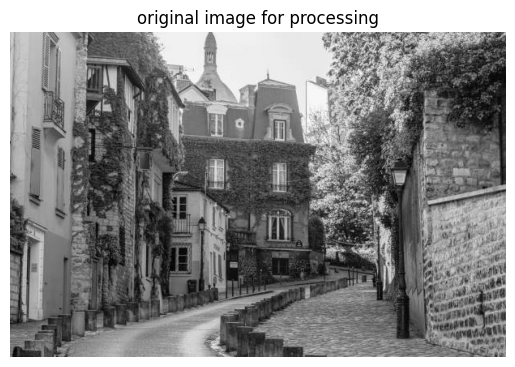

In [2]:
# read image part

image = cv2.imread('paris.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title("original image for processing")
plt.axis('off')
plt.show()


In [3]:
def wavelet_transform(img , wavelet_name ='haar' , level =1 ):
    # perform Discrete Wavelet Transform and then returen the coeffs
    coeffs = pywt.dwt2(img, wavelet_name)
    LL , (LH,HL,HH) = coeffs
    return LL , (LH, HL, HH)
def wavelet_inverse( LL, subbands, wavelet_name='haar'):
    #inverse it
    return pywt.idwt2((LL, subbands), wavelet_name)

    
# Apply transform
LL, (LH, HL, HH) = wavelet_transform(image)

# Save coefficients 
np.savez('wavelet_coeffs.npz', LL=LL, LH=LH, HL=HL, HH=HH)

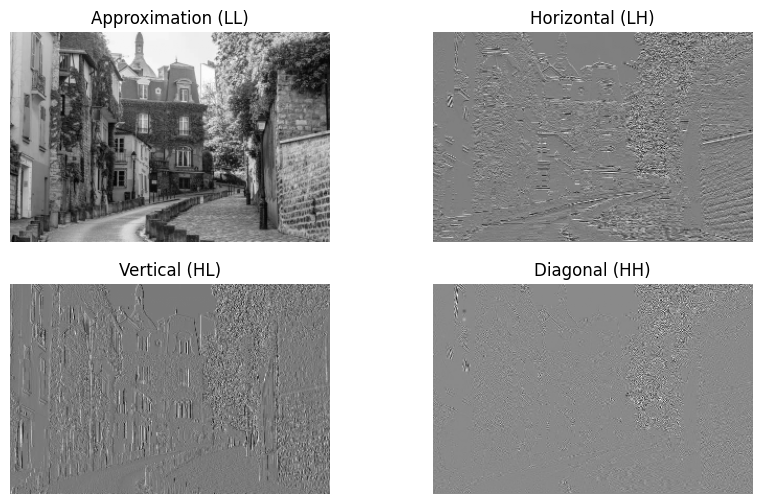

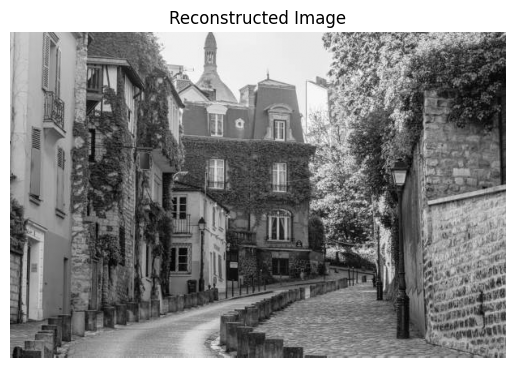

In [4]:
# Show subbands
plt.figure(figsize=(10, 6))
titles = ['Approximation (LL)', 'Horizontal (LH)', 'Vertical (HL)', 'Diagonal (HH)']
for i, band in enumerate([LL, LH, HL, HH]):
    plt.subplot(2, 2, i + 1)
    plt.imshow(band, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

# Reconstruct image
reconstructed = wavelet_inverse(LL, (LH, HL, HH))
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


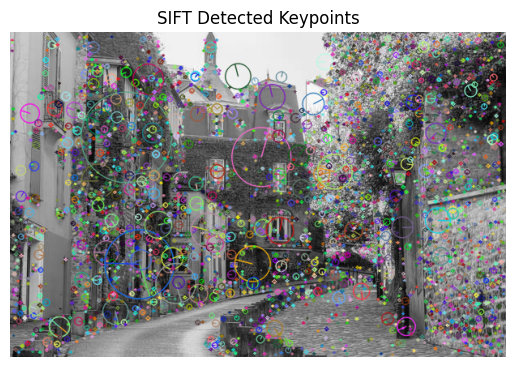

In [5]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
keypoints = sift.detect(image, None)

# Draw keypoints (BGR from OpenCV) and convert to RGB for Matplotlib
img_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_sift = cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB)

plt.imshow(img_sift)
plt.title("SIFT Detected Keypoints")
plt.axis('off')
plt.show()


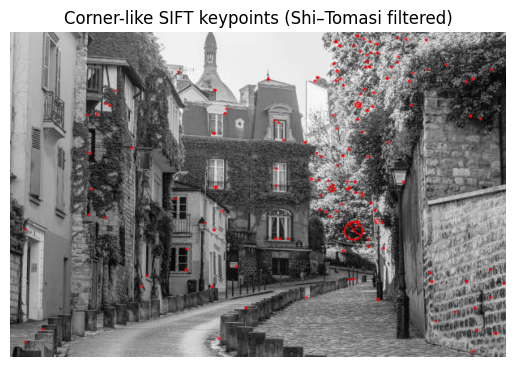

In [6]:
# Compute corner response map (Shi–Tomasi) and filter SIFT keypoints

# Ensure grayscale in [0, 1] float32
gray_f32 = image.astype(np.float32) / 255.0

# Corner response map: Shi–Tomasi (minimum eigenvalue of gradient covariance)
corner_resp = cv2.cornerMinEigenVal(gray_f32, blockSize=3, ksize=3)

# Filter SIFT keypoints using the corner metric and rank strongest

def filter_keypoints_by_response(keypoints, response_map, percentile=95, top_n=200):
    h, w = response_map.shape
    thresh = float(np.percentile(response_map, percentile))
    filtered = []
    scores = []
    for kp in keypoints:
        x = int(round(kp.pt[0]))
        y = int(round(kp.pt[1]))
        if 0 <= x < w and 0 <= y < h:
            score = float(response_map[y, x])
            if score >= thresh:
                filtered.append(kp)
                scores.append(score)
    if not filtered:
        return []
    order = np.argsort(scores)[::-1]
    order = order[:min(top_n, len(order))]
    return [filtered[i] for i in order]

corner_like_kps = filter_keypoints_by_response(keypoints, corner_resp, percentile=95, top_n=200)

# Visualize on the original image
img_corners_bgr = cv2.drawKeypoints(
    image,
    corner_like_kps,
    None,
    color=(0, 0, 255),  # red in BGR
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
img_corners_rgb = cv2.cvtColor(img_corners_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_corners_rgb)
plt.title("Corner-like SIFT keypoints (Shi–Tomasi filtered)")
plt.axis('off')
plt.show()


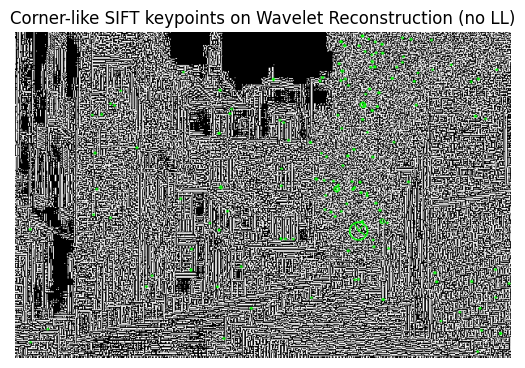

In [7]:
# Remove LL subband by setting it zero
zero_LL = np.zeros_like(LL)

# Reconstruct using zeroed LL
reconstructed_no_LL = wavelet_inverse(zero_LL, (LH, HL, HH))

# Plot corner-like SIFT keypoints on top of reconstruction
img_with_keypoints_bgr = cv2.drawKeypoints(
    reconstructed_no_LL.astype(np.uint8),
    corner_like_kps,
    None,
    color=(0,255,0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
img_with_keypoints_rgb = cv2.cvtColor(img_with_keypoints_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_with_keypoints_rgb)
plt.title("Corner-like SIFT keypoints on Wavelet Reconstruction (no LL)")
plt.axis('off')
plt.show()
